## FDW Crop Production Data Analysis - South Africa

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# # FDW API host address -------------------------- #
# host = 'https://fdw.fews.net'
# auth = tuple(json.loads(open('token.json', "r").read()))
# parameters = {
#     'format': 'json',
#     'country': 'South Africa',
#     'product': 'R011',
#     'survey_type': 'crop:best'
# }
# endpoint = '/api/cropproductionindicatorvalue/'
# response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
# response.raise_for_status()
# df = pd.DataFrame.from_records(response.json())
# df_origin = df.copy()
# # ----------------------------------------------- #

# # FDW raw data
# df = df_origin.copy()
# df = df[df['fnid'] != 'ZA1994A0'].reset_index(drop=True)
# df = df[
#     (df['status'] == 'Collected') &
#     (df['season_name'] == 'Summer') &
#     (df['indicator'] == 'Quantity Produced') &
#     (df['product'].isin(['Maize Grain (White)', 'Maize Grain (Yellow)']))
# ]
# # Drop duplicated values by selecting values having more recent "collection_date".
# cols = ['fnid','product','season_name','season_date','indicator','value']
# df = df.sort_values(by=['collection_date']).drop_duplicates(cols, keep='last').reset_index(drop=True)
# df['year'] = pd.to_datetime(df['season_date']).dt.year
# data = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1)
# years = np.array(data.index)

In [4]:
# Load GSCD crop data
country_iso, country_name = 'ZA', 'South Africa'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
data_fdw = df[
    (df['season_name'] == 'Summer') &
    (df['product'].isin(['Maize (White)','Maize (Yellow)'])) &
    (df['indicator'] == 'production')
]
data_fdw['year'] = data_fdw['growing_year']
data_fdw = data_fdw.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('Maize')
data_fdw.index = data_fdw.index - 1

# Load FAO-STAT National Production Data
df = pd.read_csv('./data/crop/adm_fao_stat.csv', index_col=0)
data_fao1 = df[
    (df['cnt_name'] == 'South Africa') &
    (df['cpc2_name'] == 'Maize (corn)') &
    (df['indicator'] == 'Production')
].set_index('year')['value']
data_fao1.index = data_fao1.index - 1

# Load FAO-AgroMaps Subnational Production Data
df = pd.read_csv('./data/crop/adm_fao_agromaps.csv', index_col=0, low_memory=False)
data_fao2 = df[
    (df['cnt_name'] == 'South Africa') &
    (df['cpc2_name'] == 'Maize (corn)') &
    (df['adm_level'] == 1) &
    (df['indicator'] == 'Production')
].pivot_table(index='year',columns='admx_code',values='value')
# print(data_fao2)
data_fao2.index = data_fao2.index - 1
data_fao2 = data_fao2.sum(1)

# Merge all data
data = pd.concat([data_fdw,data_fao1,data_fao2], axis=1, keys=['FDW','FAO_STAT','FAO_AMAP']).sort_index()
data.tail()

,FDW,FAO_STAT,FAO_AMAP
year,,,
2015,7536875.0,7778500.0,NaN
2016,16820000.0,16820000.0,NaN
2017,12889450.0,12510000.0,NaN
2018,11186320.0,11275500.0,NaN
2019,NaN,15300000.0,NaN


In [5]:
# Load precipitation
prcp = pd.read_hdf('./data/adm.prcp.chirps-v2.crop.hdf')[fnids]
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=4)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=1).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == 10]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = 'ONDJ PRCP (mm)'
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'Correlation:\n{corr_value}')

Correlation:
               FDW  FAO_STAT  FAO_AMAP      PRCP
FDW       1.000000  0.969140  0.972340  0.318648
FAO_STAT  0.969140  1.000000  0.974926  0.259693
FAO_AMAP  0.972340  0.974926  1.000000  0.729243
PRCP      0.318648  0.259693  0.729243  1.000000


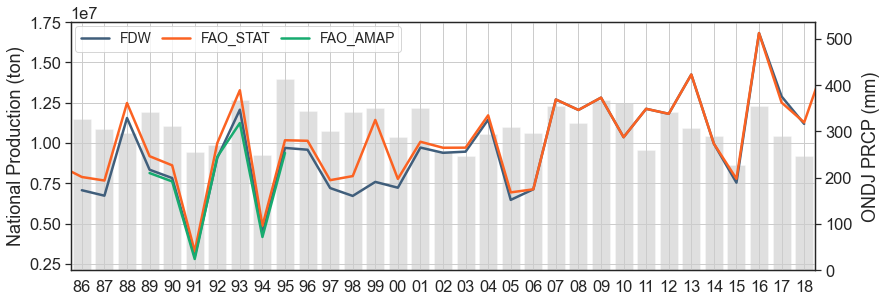

In [6]:
years = data['FDW'].dropna().index
sns.set(style="white", font_scale=1.5)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
data.plot(ax=ax1, legend=None, linewidth=2.5, marker=None, color=['#405E7B','#FB6222','#17AB6F'])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Production (ton)')
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.453, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()